<font size = "5"> **Day 2: [Diffraction and 4D-STEM and Machine Learning](../MLSTEM2024.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

[Download](https://raw.githubusercontent.com/gduscher/MLSTEM2024//main/Day2/4_iDPC.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MLSTEM2024/blob/main/Day2/4_iDPC.ipynb)


# 4D-STEM and Differential Phase Contrast
Lecturer: Gerd Duscher

part of the workshop of 

<font size = "5"> **[Machine Learning in Scanning Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>


**Day2: Electron Diffraction, 4D-STEM, Differential Phase Contrast, and Variational Auto
Encoder**
<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
    <td></td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**June 2024**

## Overview
We calculate CBED pattern for a scanned area to demonstrate how to derive DPC from CBED pattern of 4D-STEM data set or from images obtained with segmented detectors.

This is important to get training data for further machine learning algorithms and for an understanding of the physical content of the data. 

## Load packages
### Check for Newest Versions

In [13]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.2.3':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
    !{sys.executable} -m pip install  --upgrade abtem -q

print('done')

done


In [14]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import output
    from google.colab import drive
    output.enable_custom_widget_manager()
import ase
import abtem
import scipy

# Simulating 4D-STEM Data

*This notebook is modified version of the abTEM notebook [Scan and Detect](https://abtem.readthedocs.io/en/latest/user_guide/walkthrough/scan_and_detect.html).*

Scanning imaging modes such as STEM work by rastering a focused electron probe across the sample pixel by pixel, and recording the scattering signal for each position. To simulate this we have to perform a multislice simulation of a CBED pattern for each probe position.

## Scanned multislice
We start by creating a model of MoS<sub>2</sub>, whose unit cell we repeat to accomodate the size of the probe wave function 

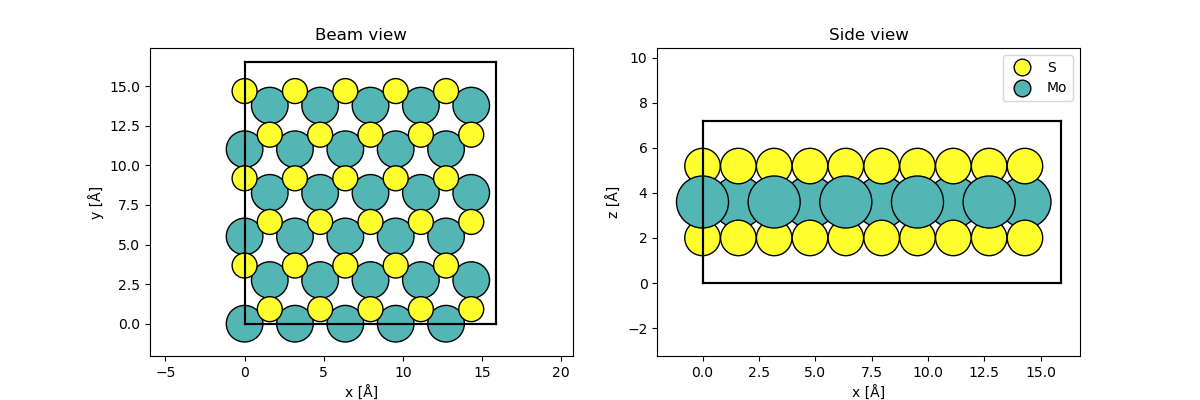

In [26]:
atoms = ase.build.mx2(vacuum=2)

atoms = abtem.orthogonalize_cell(atoms)

atoms = atoms * (5, 3, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, title="Beam view", ax=ax1)
abtem.show_atoms(atoms, legend=True, plane="xz", title="Side view", ax=ax2);

Next, we create a `Potential` with a sampling of $0.05 \ \mathrm{Å}$ and a `Probe` with an energy of $60 \ \mathrm{keV}$ and a convergence semiangle of $20 \ \mathrm{mrad}$ (and match its sampling to the potential).

In [27]:
# ---- Input ------
convergence_angle = 20
acceleration_voltage = 80*1e3
# ------------------
potential = abtem.Potential(atoms, sampling=0.05)

probe = abtem.Probe(energy=acceleration_voltage, semiangle_cutoff=convergence_angle)
probe.grid.match(potential)

*ab*TEM implements three scan types:

* `GridScan`: Uniformly spaced axis-aligned 2D grid of probe positions.
* `LineScan`: Uniformly spaced probe positions along a line with an arbitrary direction.
* `CustomScan`: Defines the probe positions as an arbitrary $N \times 2$ array of numbers.

We use the most commonly used `GridScan`.

## Applying detectors
In experiments, the exit wave functions are measured using detectors, and correspondingly *ab*TEM implements several detector types. For now, we shall focus on the `AnnularDetector`, which, depending on the choice of integration region, can represent the detector used in bright-field, medium- or high-angle annular dark-field microscopy, abbreviated BF, MAADF and HAADF, respectively.

Below we create a detector for BF, MAADF and HAADF by specifying the inner and outer radial integration angle in $\mathrm{mrad}$.

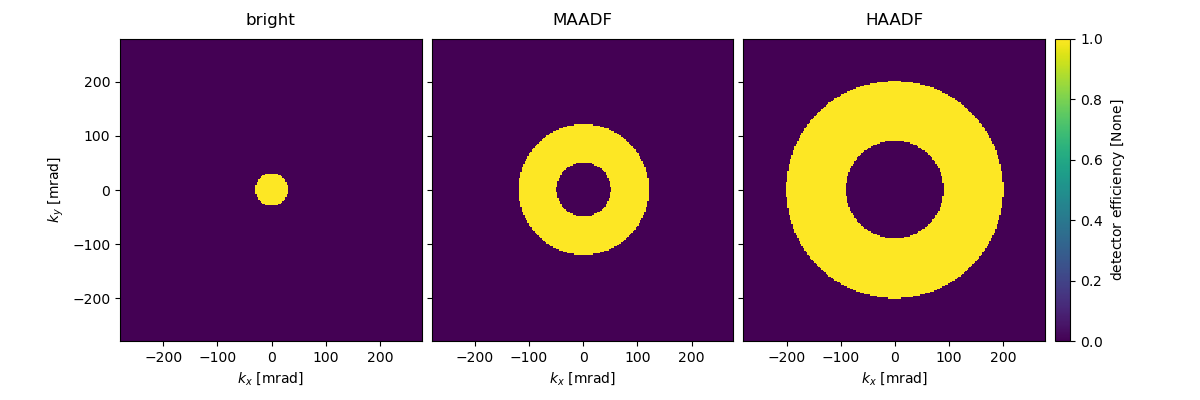

In [28]:
bright = abtem.AnnularDetector(inner=0, outer=30)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=90, outer=200)

bright = abtem.AnnularDetector(inner=0, outer=30)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=90, outer=200)

bright_region = bright.get_detector_region(probe)
maadf_region = maadf.get_detector_region(probe)
haadf_region = haadf.get_detector_region(probe)

stacked_regions = abtem.stack(
    (bright_region, maadf_region, haadf_region), ("bright", "MAADF", "HAADF")
)

visualization = stacked_regions.show(
    explode=True, cbar=True, common_color_scale=True, units="mrad", figsize=(12, 4)
)


We note that the maximum simulated angle ($278 \ \mathrm{mrad}$) is greater than the maximum detected angle ($200 \ \mathrm{mrad}$). An error will be thrown, if this is not true, in which case you need to increase the real-space `sampling` of the `Probe`.

The detector regions, given a wave function, may be retrieved using the get detector region. We stack the detector regions and show them.

## STEM simulations

We perform typical STEM simulations using a `GridScan` much the same as we did with the `LineScan` above. We define a scan across a periodic unit of the potential using fractional coordinates by setting `fractional=True`, thus the arguments for stafrt and end will be . 

The probe step size (or `sampling`) is set to the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency) of the probe contrast transfer function.

In [29]:
sampling = probe.aperture.nyquist_sampling
print(f"Nyquist sampling = {sampling:.3f} Å/pixel")

Nyquist sampling = 0.522 Å/pixel


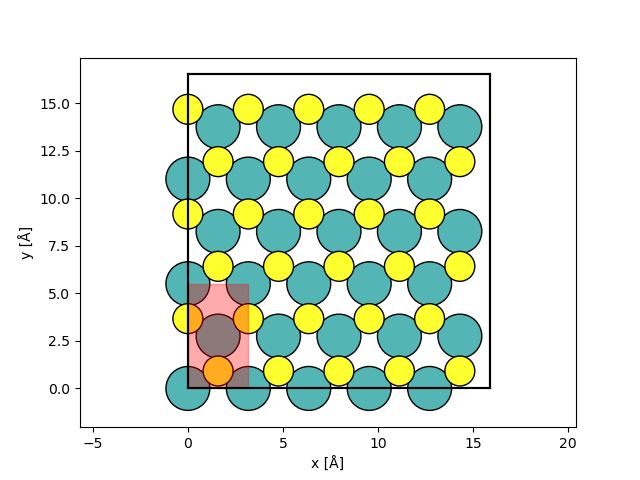

In [30]:
grid_scan = abtem.GridScan(
    start=[0, 0],
    end=[1 / 5, 1 / 3],
    sampling=sampling,
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(atoms)
grid_scan.add_to_plot(ax)

We set up the STEM simulation, which will result in a list of `Images`. 

In [31]:
all_detectors = [bright, maadf, haadf]
measurements = probe.scan(potential, scan=grid_scan, detectors=all_detectors)

It is convenient to stack the measurements into a single `Images` object, so that they can be saved as a single file.

In [32]:
measurements = abtem.stack(measurements, ("BF", "MAADF", "HAADF"))

We keep the caluculation in memory as a dask array, so we need to initiate the calculation explicitly (this will take around 20 s).

In [33]:
measurements.compute()

[########################################] | 100% Completed | 18.36 ss


We show the resulting `Images` below.

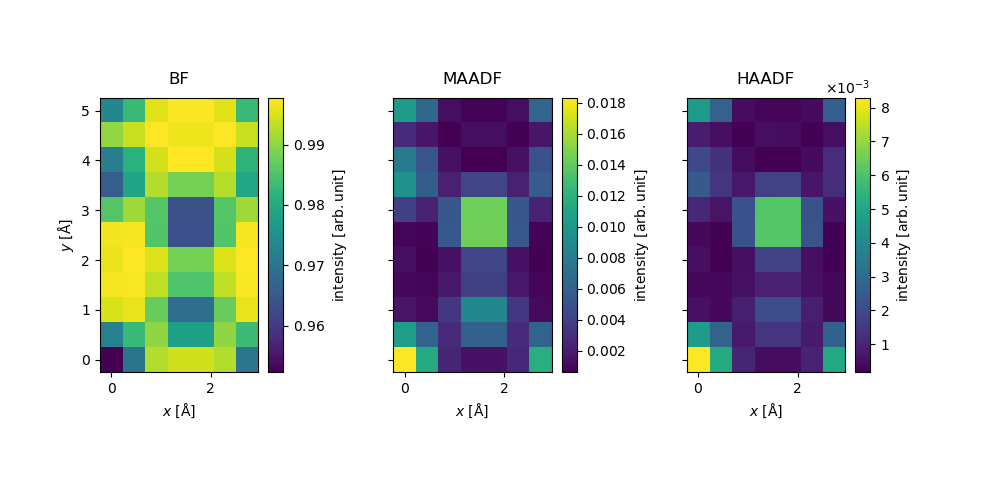

In [35]:
measurements.show(explode=True, cbar=True, figsize=(10, 5));

## Post-processing STEM measurements

STEM simulations usually requires some post-processing, and we apply the most common steps below.

### Interpolation

We saved a lot of computational time by scanning at the Nyquist frequency, but the result is quite pixelated. To address this, we interpolate the images to a sampling of $0.1 \ \mathrm{Å / pixel}$. *ab*TEM's default interpolation algorithm is Fourier-space padding, but spline interpolation is also available, which is more appropriate if the image in non-periodic.

In [36]:
interpolated_measurement = measurements.interpolate(sampling=0.1)

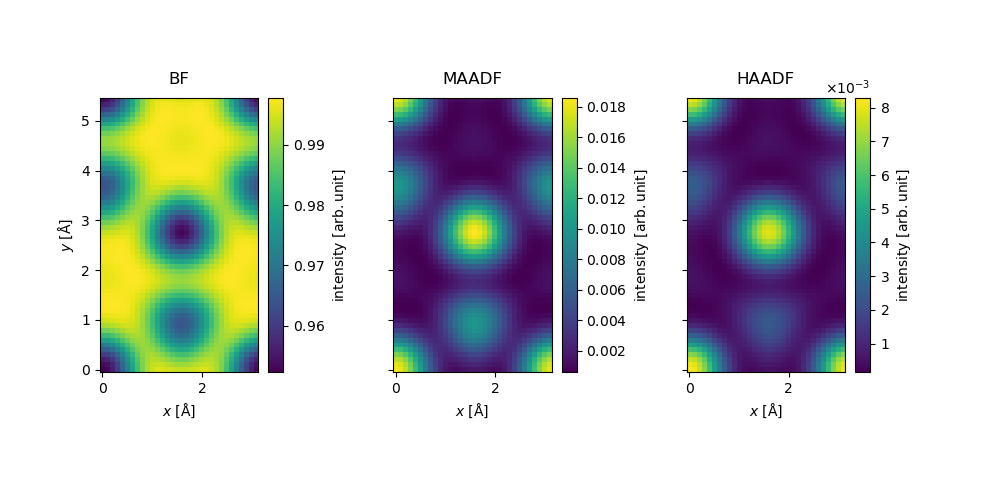

In [37]:
visualization = interpolated_measurement.show(explode=True, cbar=True, figsize=(10, 5))

# visualization.axes.set_sizes(cbar_spacing=1)

(0.0, 56.0)

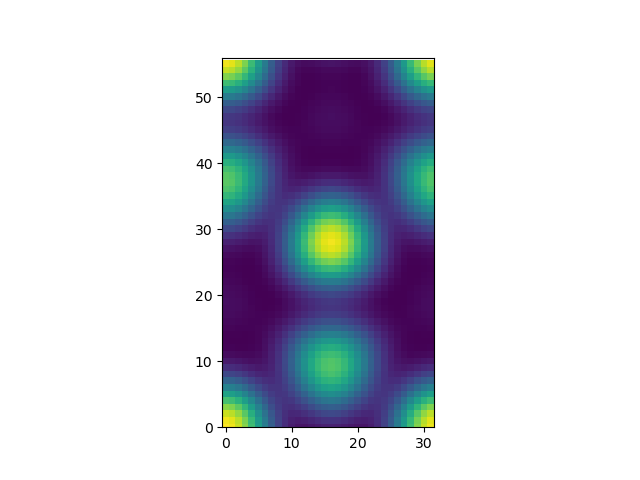

In [38]:
image  = np.array(interpolated_measurement[0].to_data_array())

image = image.max()-image

plt.figure()
plt.imshow(image.T )
plt.ylim(0, image.shape[1])

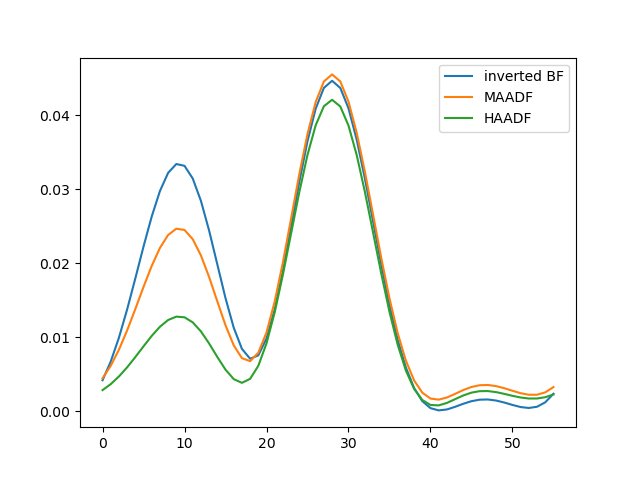

In [39]:
plt.figure()
plt.plot(image.T[:, int(image.shape[0]/2)], label='inverted BF')
image_MAADF  = np.array(interpolated_measurement[1].to_data_array())
image_HAADF  = np.array(interpolated_measurement[2].to_data_array())
plt.plot(image_MAADF.T[:, int(image_MAADF.shape[0]/2)]*2.45, label = "MAADF")
plt.plot(image_HAADF.T[:, int(image_MAADF.shape[0]/2)]*5.3, label = "HAADF")
plt.legend()

### Blurring

A finite Gaussian-shaped source will result in a blurring of the image. Vibrations and other instabilities may further contribute to the blur. We apply a Gaussian blur with a standard deviation of $0.5 \ \mathrm{Å}$ (corresponding to a source of approximately that size).

```{seealso}
We are not including partial temporal incoherence here. See our [tutorial on partial coherence](../tutorials/partial_coherence.ipynb) in STEM simulations for a detailed description, as well as a more rigorous treatment of partial spatial coherence using the contrast transfer function.
```

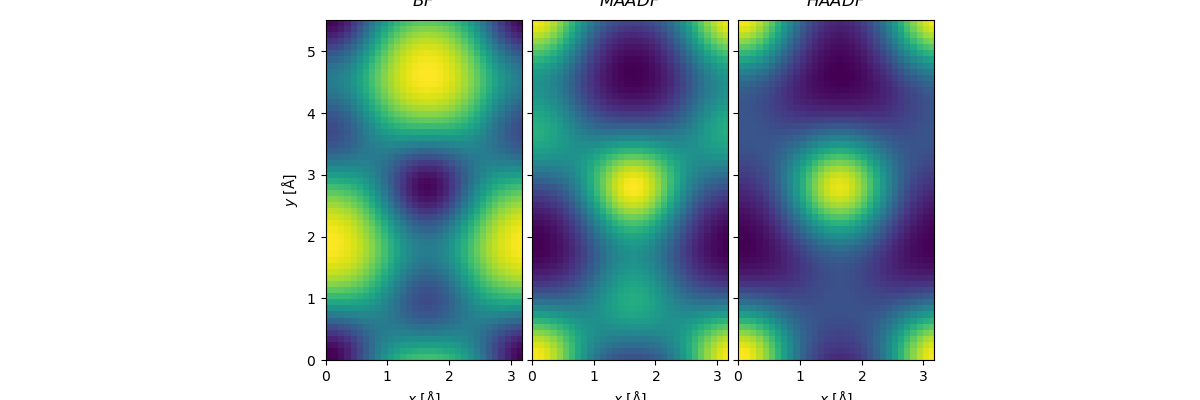

In [13]:
# ---- Input -----
blur = 0.5  # in Angstrom
# -----------------
blurred_measurement = interpolated_measurement.gaussian_filter(blur)

blurred_measurement.show(explode=True, figsize=(12, 4));

### Noise

Simulations such as the above corresponds to the limit of an infinite electron dose. An image with a finite electron dose will contain [shot noise](https://en.wikipedia.org/wiki/Shot_noise). We can get a random sample for a finite dose by drawing random numbers from a Poisson distribution for every pixel. The Poisson distribution has a mean of

$$
    \lambda = \mathrm{area \ per \ pixel} \times \mathrm{dose \ per \ area} \times \mathrm{intensity} \quad ,
$$

where it is assumed that intensity of the reciprocal space probe is normalized to integrate to $1$.

Before applying the noise, we tile the images to get better statistics.

In [14]:
tiled_measurement = blurred_measurement.tile((7, 4))

We apply Poisson noise corresponding a dose per area of $10^5 \ \mathrm{e}^- / \mathrm{Å}^2$.

In [16]:
# ----Input ------
dose = 1e5
# ----------------
noisy_measurement = tiled_measurement.poisson_noise(dose_per_area=dose, seed=100)

While most of the electrons are collected in BF, we get the best signal in MAADF and HAADF provides the best Z-contrast.

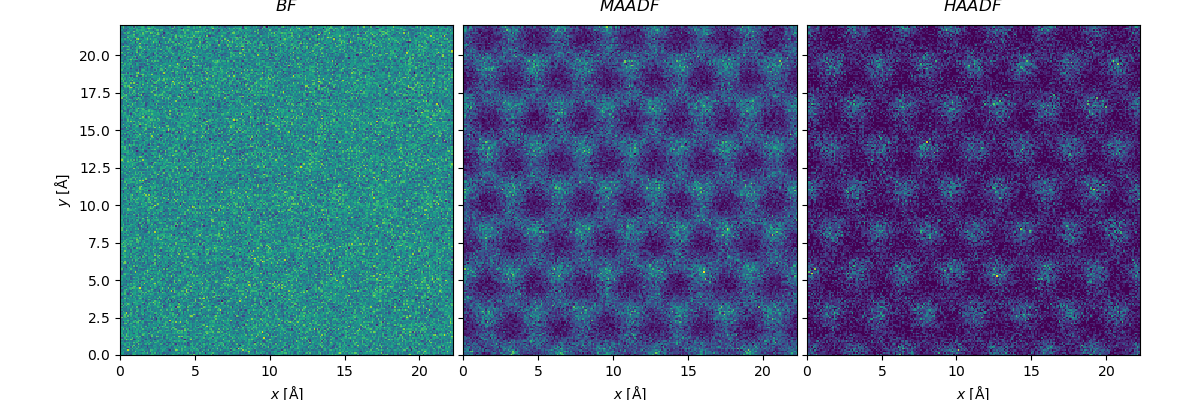

In [17]:
noisy_measurement.show(explode=True, figsize=(12, 4));

Poisson noise is generally the most important source of noise in STEM images, here we ignore scan noise due to vibrations and voltage instabilities in the scan coils. For completeness, we note that thermal noise in the detector material may also contribute. 

## Detectors

Many kinds of detectors are widely used in STEM, and *ab*TEM accordingly implements the following detector types:

* `AnnularDetector`: Integrates diffraction patterns between two scattering angles. Used for BF, MAADF and HAADF.
* `FlexibleAnnularDetector`: Bins diffraction patterns in radial regions. Used for BF, MAADF and HAADF, allowing the angles to be adapted after the simulation.
* `SegmentedDetector`: Bins diffraction patterns in radial and azimuthal regions. Used for differential phase constrast STEM (DPC-STEM).
* `PixelatedDetector`: Detects full diffraction patterns. Used for 4D-STEM.
* `WavesDetector`: Detects the full wave function. Mostly for internal use.

The `AnnularDetector` was introduced in the preceding section, and in the following the rest of the detectors are discussed.


### `SegmentedDetector`

The `SegmentedDetector` covers an annular region and is partitioned into several detector regions forming radial and azimuthal segments. 

Below we define a `SegmentedDetector` covering the annular region between $40$ and $80 \ \mathrm{mrad}$. It is divided 
into $2$ radial regions, each of which are divided into $4$ azimuthal regions. The detector regions are rotated by $45 \ \mathrm{deg.}$ with respect to the cartesian axes.

In [40]:
segmented_detector = abtem.SegmentedDetector(
    inner=40, outer=80, nbins_radial=2, nbins_azimuthal=4, rotation=np.pi / 4
)

We may illustrate the detector regions below.

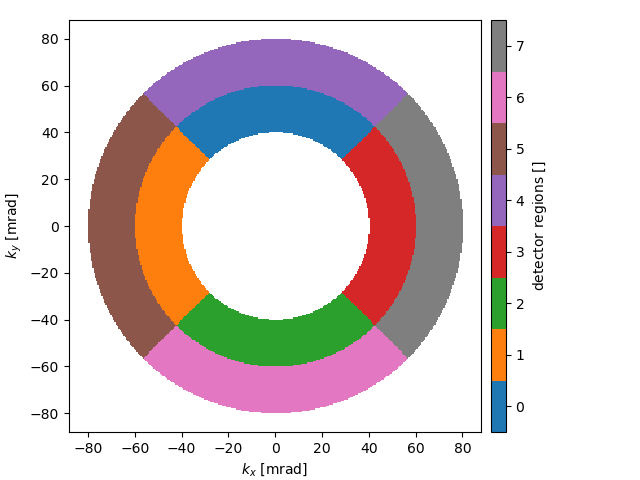

In [41]:
segmented_detector.show(probe, cbar=True);

We then run the scanned multislice simulation. 

In [42]:
segmented_measurement = probe.scan(
    potential, scan=grid_scan, detectors=segmented_detector
)

The resulting `PolarMeasurement` is 4D, the first two (ensemble) axes representing the scan directions and the last two (base) axes represents the radial and azimuthal bin axes.

In [43]:
segmented_measurement.shape

(7, 11, 2, 4)

In [44]:
segmented_measurement.axes_metadata

type        label                             coordinates
----------  --------------------------------  ------------------
ScanAxis    x [Å]                             0.00 0.45 ... 2.73
ScanAxis    y [Å]                             0.00 0.50 ... 5.01
LinearAxis  Radial scattering angle [mrad]    40.00 60.00
LinearAxis  Azimuthal scattering angle [rad]  0.79 2.36 ... 5.50

In [45]:
segmented_measurement.compute()

[########################################] | 100% Completed | 18.88 ss


We show the detected intensities for scan positions along $x$ at $y=0.5 \ \mathrm{Å}$ on a polar plot. We see that the electrons attracted toward the positions of the Mo atoms.

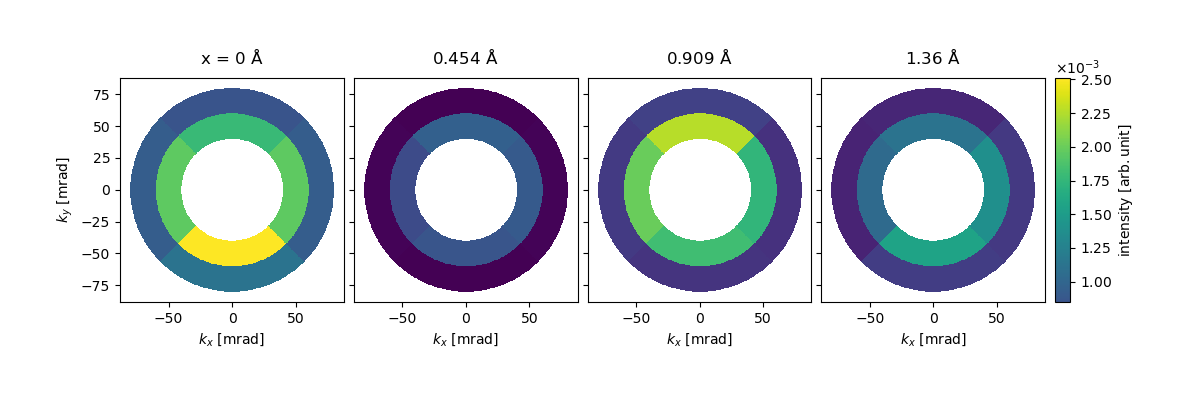

In [46]:
segmented_measurement[::2, 1].show(
    cbar=True, explode=True, common_color_scale=True, units="mrad", title=True, figsize=(12,4)
);

Below we calculate the differential signals in the $x$- and $y$-directions. The differential signal in the $x$-direction is calculated as the difference between detector regions 1 and 3, for the $y$-direction it is the difference between detector regions 0 and 2.

In [47]:
differential = segmented_measurement.differentials(
    direction_1=[(3,), (1,)],
    direction_2=[(2,), (0,)],
    return_complex=True,
)

The differential signal is returned as complex `Images`, where the real and imaginary parts correspond to the $x$- and $y$-direction, respectively.

To show the results, we first interpolate and tile. The different representations of the complex parts are stacked to show them as an exploded plot.

C:\Users\gduscher\AppData\Local\anaconda3\Lib\site-packages\abtem\visualize\visualizations.py:183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


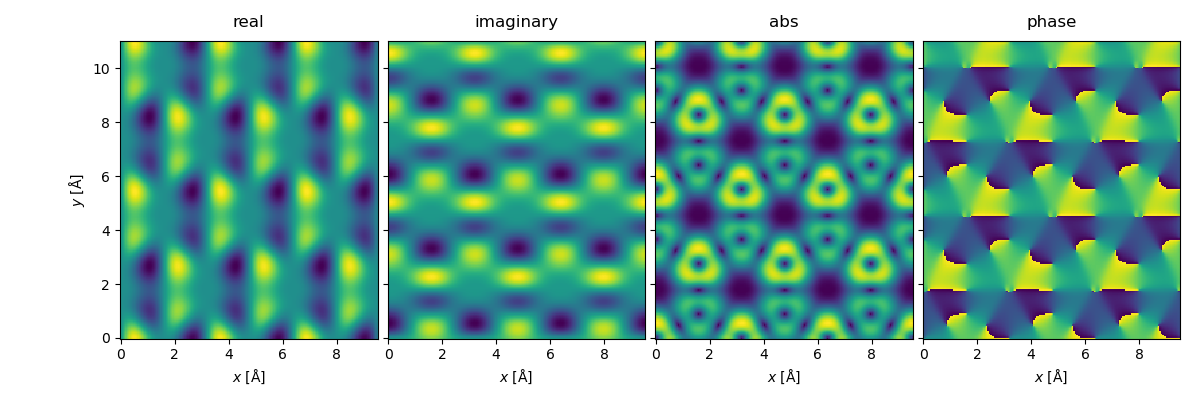

In [48]:
interpolated_differential = (
    differential.interpolate(0.05).gaussian_filter(0.3).tile((3, 2))
)

abtem.stack(
    [
        interpolated_differential.real(),
        interpolated_differential.imag(),
        interpolated_differential.abs(),
        interpolated_differential.phase(),
    ],
    ("real", "imaginary", "abs", "phase"),
).show(explode=True, figsize=(12, 4));

We can also display the complex `Images` using domain coloring.

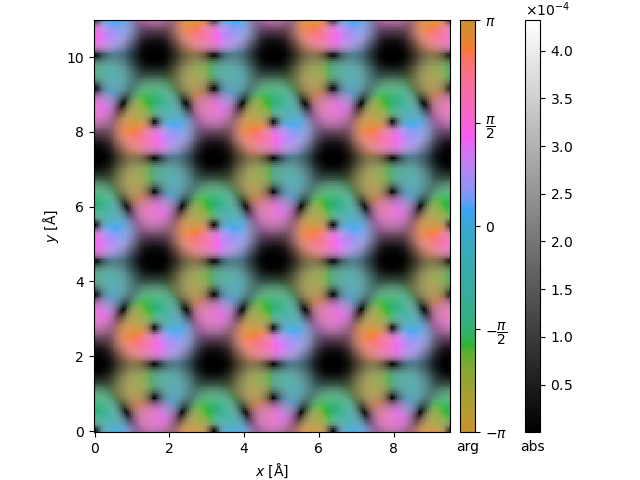

In [51]:
interpolated_differential.show(cbar=True);

### `PixelatedDetector`

The `PixelatedDetector` records the diffraction patterns for every probe position. Hence, a 2D scan with this detector results in a four-dimensional dataset. The 4D datasets can be used to reconstruct the results of all the other detector geometries. 

Below we create a `PixelatedDetector` saving the diffraction patterns up to $200 \ \mathrm{mrad}$ and run the scanned multislice algorithm.

In [52]:
pixelated_detector = abtem.PixelatedDetector(max_angle=200)

pixelated_measurements = probe.scan(
    potential,
    scan=grid_scan,
    detectors=pixelated_detector,
)
pixelated_measurements.compute()

[########################################] | 100% Completed | 15.55 ss


We show the detected intensities for scan position `(1, 1)` up to $80 \ \mathrm{mrad}$. Since the diffraction pattern is often dominated by the direct disk, it is sometimes preferable to block the direct intensity.

We can make the same observation, as we did for the `SegmentedDetector`: the electrons are attracted in the direction of the atomic potential.

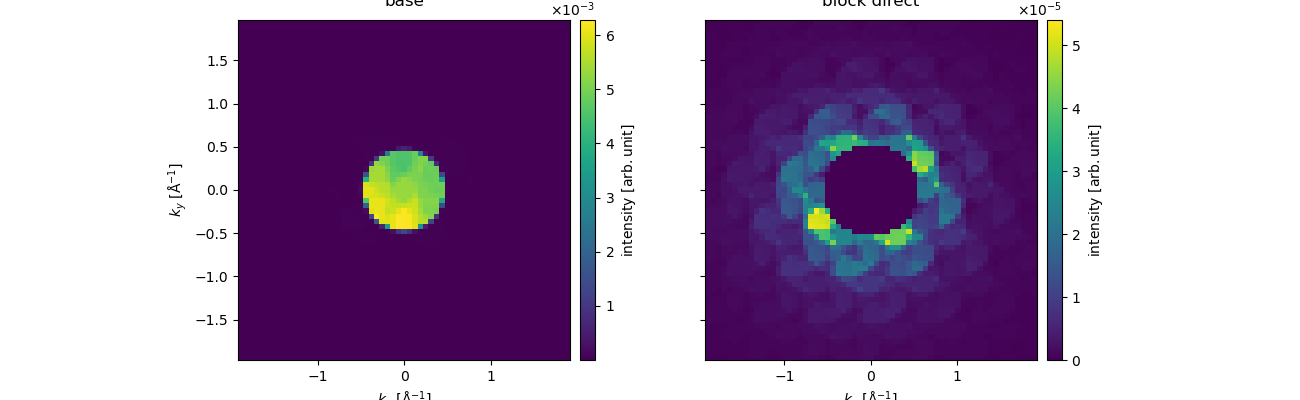

In [55]:
cropped_diffraction_pattern = pixelated_measurements[1, 1].crop(max_angle=80)

abtem.stack(
    [
        cropped_diffraction_pattern,
        cropped_diffraction_pattern.block_direct(),
    ],
    ("base", "block direct"),
).show(explode=True, cbar=True, figsize=(13, 4));

As an alternative to blocking the direct disk, we can show the diffraction pattern on a power scale to relatively enhance the low intensities.

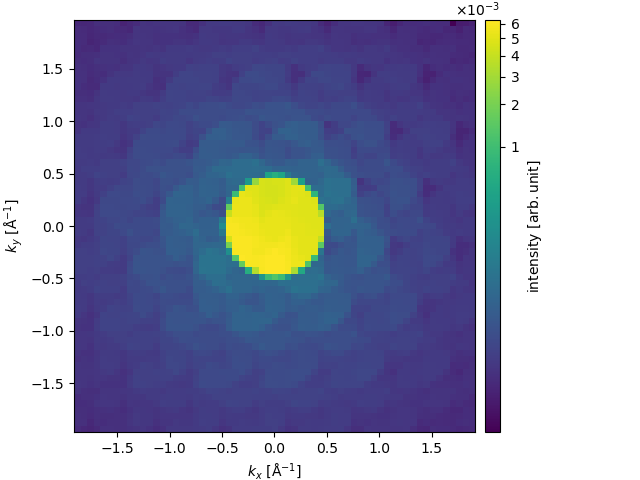

In [56]:
cropped_diffraction_pattern.show(power=0.2, cbar=True);

We can obtain the annular integrated measurements from the diffraction patterns by integrating radially as shown below.

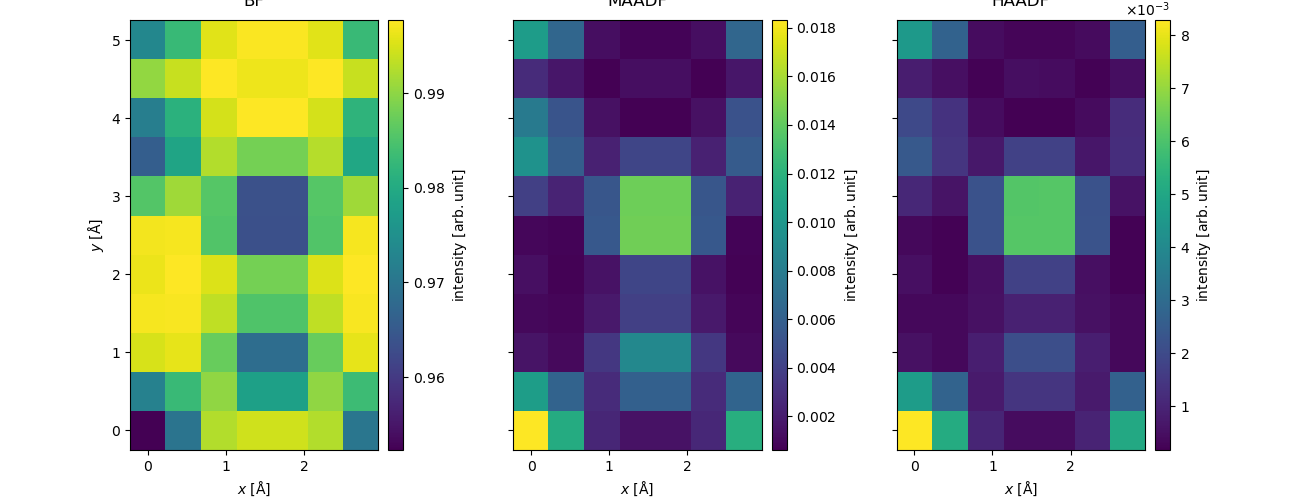

In [57]:
stacked = abtem.stack(
    [
        pixelated_measurements.integrate_radial(0, 30),
        pixelated_measurements.integrate_radial(50, 120),
        pixelated_measurements.integrate_radial(90, 200),
    ],
    ("BF", "MAADF", "HAADF"),
)

stacked.show(explode=True, cbar=True, figsize=(13, 5));

The center of mass, $\vec{I}_{com}(\vec{r}_p)$, of the diffraction pattern at a probe position, $\vec{r}_p$, may be calculated as

$$
    \vec{I}_{com}(\vec{r}_p) = \int \hat{I}(\vec{k}, \vec{r}_p) \vec{k} d^2\vec{k} \quad ,
$$

where $\hat{I}(\vec{k})$ is a diffraction pattern intensity. Doing this for every diffraction pattern, we obtain the image shown below. The center of mass is returned as complex `Images`, where the real and imaginary parts correspond to the $x$- and $y$-direction, respectively. We set `units="reciprocal"`, hence each complex component is in units of $\mathrm{Å}^{-1}$.

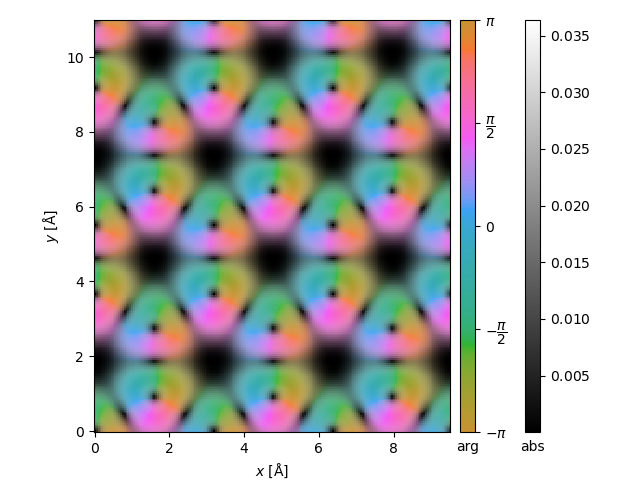

In [58]:
center_of_mass = pixelated_measurements.center_of_mass(units="1/Å")

interpolated_center_of_mass = center_of_mass.interpolate(0.05).tile((3, 2))

interpolated_center_of_mass.show(cbar=True);

It may be shown{cite}`lazic_idpc`, in the weak-phase approximation, that by integrating $\vec{I}_{com}(\vec{r}_p)$, we can obtain the phase change of the exit wave, $\varphi(\vec{r_p})$, cross-correlated with the probe intensity

$$
\vec{I}_{iCOM}(\vec{r}_p) = \frac{1}{2\pi} \left[\|\psi_0(\vec{r})\|^2 \star \varphi(\vec{r})\right](\vec{r}_p) \quad .
$$

This is the so-called integrated center of mass. We can calculate this using the `integrate_gradient` method, which assumes a complex `Image`.

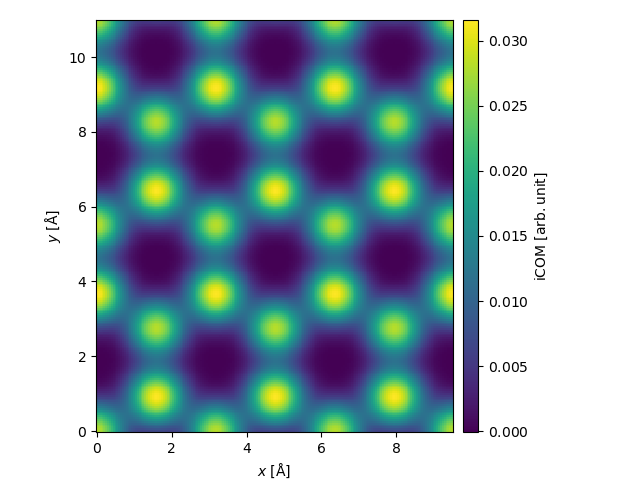

In [59]:
integrated_gradient = center_of_mass.integrate_gradient()

interpolated_integrated_gradient = integrated_gradient.interpolate(0.05).tile((3, 2))

interpolated_integrated_gradient.show(cbar=True);

## DPC, iDPC, COM and iCOM

Let's explore a in a little more detail what we did above and how we can interprete those signals.


The center of mass (COM) and its integrated form (iCOM) are the ideal of the differential phase contrast (DPC) and it's integrated form (iDPC), because the center of mass is evaluated through segmented detectors. [Shibata et al.](https://doi.org/10.1093/jmicro/dfq014) showed that such a differential phase contrast (DPC) imaging can be done with atomic resolution. Above we saw that the COM from the CBED patterns results in almost the same image as with the segmented detectors. 

Even the CBED pattern for each pixel in 4D-STEM is only an approximation because of the pixelated nature and noise.

While the Z-contrast images obtained with high-angle anular dark field (HAADF) detectors are linear with idealy the atomic number squared (each atom adds linearly to the intensity with it's squared atomic number Z), the iDPC images are truly linear in the atomic number Z. This allows to image lighter atoms better even if they are close to heavy atoms.

There are two important factors that provide an advantage for iDPC compared to Z-contrast imaging:

* **More electrons** are detected in DPC and iDPC than in a Z-contrast images with it's large angles, resulting in less detector and quantum mechanical shot noise.
* Only the **conservative part of a vector field** contributes to the integration process for the iDPC image and thus supresses the largely non-conservative noise, increases noise for low spatial frequencies. The conservative part of the vector field is the part fo the electrical field that can be written as the gradient of a scalar field.
  

### Center of Mass in CBED

The determination of the CBED pattern has been discussed previously now we study the center of mass (COM) of a CBED pattern.

<img src="images/center_of_mass.png" alt="center of mass" width="300" >

Because  [Lasic et al](https://doi.org/10.1016/j.ultramic.2015.10.011)  showed that the COM image is formed by a cross-correlation rather than a convolution between the probe intensity $|\psi_{in}(\vec{r})|^2$ 
and the gradient of the phase shift $\vec{\nabla}\varphi(r)$:

$$ \vec{I}_{COM}(\vec{r}_p) =   
\frac{1}{2\pi} \left( |\psi_{in}(\vec{r})|^2 \times \vec{\nabla} \varphi(\vec{r}) \right)(\vec{r}_p)
$$

To obtain a scalar image linearly dependent on the phase shift directly we need to integrate the center of mass image.

Following [Lasic et al](https://doi.org/10.1016/j.ultramic.2015.10.011) 
the gradient of this integrated center of mass image is then the center of mass vector image directly.

$$ \vec{I}_{COM}(\vec{r}_p) =   \vec{\nabla} I_{iCOM}(\vec{r}_p)
$$

Integration in Fourier domain yields:
$$ \mathcal{F}\left\{I_{iCOM} (\vec{r}_p)  \right\}  (\vec{k}_p) = \frac{\vec{k}_p  \mathcal{F}\left\{\vec{I}_{COM} (\vec{r}_p)  \right\}  (\vec{k}_p) }{2 \pi k^2_p}
$$
for $k_p \ne 0$.


[Lasic et al](https://doi.org/10.1016/j.ultramic.2015.10.011)  derive the following linear dependency of iCOM with the phase shift $\varphi(\vec{r})$:
$$
I_{iCOM}(\vec{r}_p) = \frac{1}{2\pi} \left(|\psi_{in}(\vec{r})|^2 \times \varphi(\vec{r})   \right) (\vec{r}_p)
$$

### Comparison between DPC and COM
Like the center of mass, the two differencial images of a sector detector form a vector image

$$ \vec{I}_{DPC}(\vec{r}_p) = I_{DPC_x}(\vec{r}_p) \hat{e}_x + I_{DPC_y}(\vec{r}_p) \hat{e}_y $$

with integration shown above the Fourier transform of $ \vec{I}_{iDPC}$ is:

$$ \mathcal{F}\left\{\vec{I}_{iDPC} (\vec{r}_p)  \right\}  (\vec{k}_p) = \frac{\vec{k}_p  \mathcal{F}\left\{\vec{I}_{DPC} (\vec{r}_p)  \right\}  (\vec{k}_p) }{2 \pi k^2_p}
$$


From which we take the inverse Fourier transform to get the scalar iDPC image.

[Lasic et al](https://doi.org/10.1016/j.ultramic.2015.10.011) showed that the contrast transfer function shows only contrast reversal for large positive defoci.

Let's see what we need to calculate the iDPC from a vector field image and using only numpy and scipy functions.

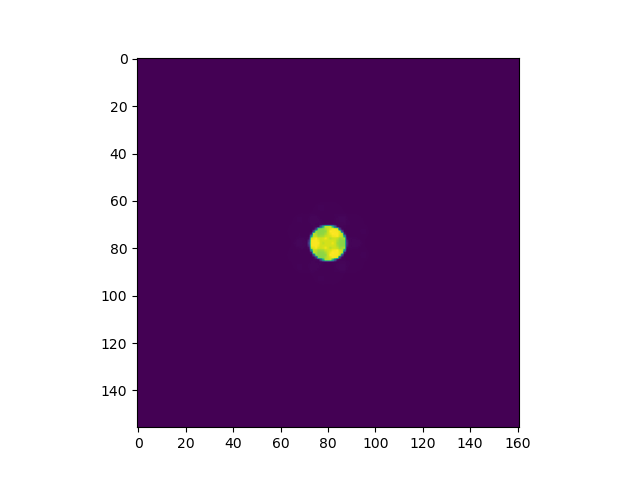

In [82]:
d4_stem = pixelated_measurements.to_data_array()

plt.figure()
plt.imshow(d4_stem[0,0])

center_of_mass = np.zeros(d4_stem.shape[:2], dtype = complex)
for x in range(d4_stem.shape[0]):
    for y in range(d4_stem.shape[1]):
        center = scipy.ndimage.center_of_mass(d4_stem[x,y])
        center_of_mass[x,y] = complex(center[0], center[1])

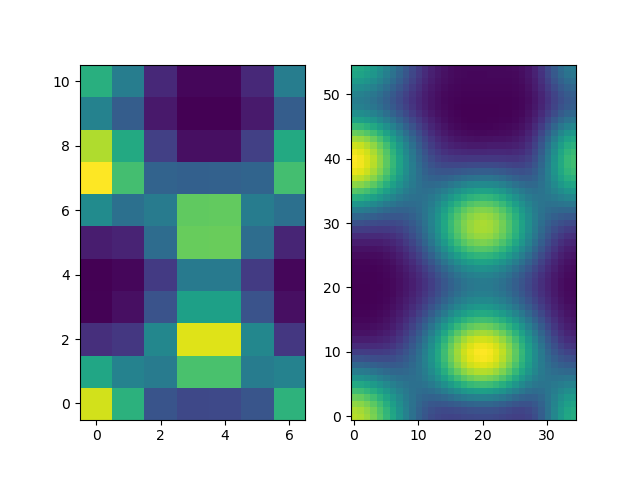

In [83]:

com = center_of_mass# .array
com_x, com_y = center_of_mass.real, center_of_mass.imag
(nx, ny) = com_x.shape[-2:]
ikx = np.fft.fftfreq(nx, pixelated_measurements.sampling[0])
iky = np.fft.fftfreq(ny, d=pixelated_measurements.sampling[1])

grid_ikx, grid_iky = np.meshgrid(ikx, iky, indexing="ij")

k = grid_ikx**2 + grid_iky**2
k[k == 0] = 1e-12
i_com_recip = (np.fft.fft2(com_x) * grid_ikx + np.fft.fft2(com_y) * grid_iky) / (2j * np.pi * k)
i_com = np.real(np.fft.ifft2(i_com_recip))
i_com -= np.min(i_com)

fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ax1.imshow(i_com.T, origin='lower')
ax2.imshow(scipy.ndimage.zoom(i_com, 5).T, origin='lower')


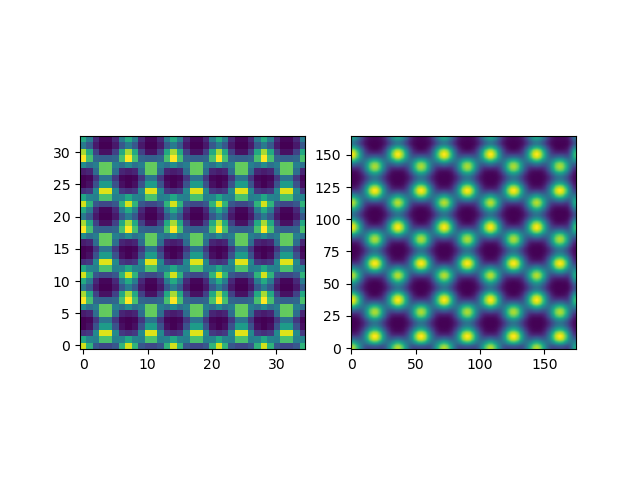

In [61]:
fig = plt.figure()
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
ax1.imshow(np.tile(i_com, [5,3]).T, origin='lower')
ax2.imshow(scipy.ndimage.zoom(np.tile(i_com, [5,3]), 5).T, origin='lower')


## Summary

With 4D-STEM or segmented detectors the inner potential or phase-shift can be obtained directly.

Any Z-contrast simulation software can be used to provide excellent training data for machine learning.